**Introduction:** The goal of this project is to predict the medical condition of SEVERAL distinct abdominal organs using only a single slice of the CT scan of the patient. Although the test data is 2D images, the labeled input data of subjects includes all slices from a 3D scan. Minority of the subjects also have segmentation masks available that indicates the position of each organi in their scans. The output labels of the model should be probability of injury for each organ. Note that some of the organs have different levels of injury (healthy/low/high).<br>

**Approach:** My approach to predict the output labels is to serialize two machine learning models as follows:
1) A deep neural network with UNet architecture that learns segmentations from the existing subjects, and expands it across all subjects.<br>
2) Once segmentations of all organs of all subjects are extracted from the UNET, raw scans masked with segmentation probabilities (i.e. UNet output) are fed into a typical CNN architecture that outputs the output labels.<br>
* UNet:       
    - Lr scheduler with cyclic triangular pattern that decays over time
    - In case of inferior performance, UNet should be implemented as in self-supervised learning. In other words, At every epoch, most confident predictions are concatenated with the original train set. This process goes on until all the unlabeled data that were assigned to train set are labeled. Finally, the model is tested on the rest of originally-labeled data for final evaluation. UPDATE: NO NEED FOR THIS!
    - Focal Tversky loss function

* CNN:
    - Segmentations are now stacked, not multiplied
    - Several loss functions are defined separately for each organ
    - BCElosswithlogits is used for organs with only 2 levels of output (healthy/injured)
    - CrossEntropy is used for organs with more than 2 levels of output (healthy/low/high)
    

**Results:** <br>
- The UNet architecture has a decent sensitivity, but it has false positives for when the slice has no positive pixels. We don't care about FPs because segmentations serve as attention weights for CNN.
- Best loss value for validation was 0.18 with not a super intensive training. Checking outputs on the train and validation data the model works very well.
- Because CNN loss is a custom function, CNN outputs logits not cross entropy or else. post_proc function translates logits to probs.
- One challenge for submission is that we have multiple predictions for each slice of a patient. We need to somehow integrate these predictions and output one prediction (without manipulation too much maybe?)

# Initializations

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import random
import re
import shutil

import sklearn.metrics as metrics

from PIL import Image as im
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms.v2 as T
import albumentations as A
from albumentations.core.transforms_interface import DualTransform

from tqdm import tqdm
import gc
import pydicom as dcm
import nibabel as nib
import pickle

# ________________________________________________________________________________________________________________ INITILIZATIONS
def set_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    return device    

def set_data_paths():
    data_path = {}
    data_path['root'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
    data_path['train'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'
    data_path['segmentations'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'
    data_path['test'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
    data_path['masks'] = '/kaggle/working/mask_slices'
    return data_path

def create_segmentation_dict():
    # Mask organ label mapping
    segmentation_dict = {}
    segmentation_dict['segmentation_class_to_inx'] = {'Background': 0, 'Liver': 1, 'Spleen': 2, 'Kidney_left': 3, 'Kidney_right': 4, 'Bowel': 5}
    segmentation_dict['segmentaiton_inx_to_class'] = {0: 'Background', 1: 'Liver', 2:'Spleen', 3:'Kidney_left', 4:'Kidney_right', 5 :'Bowel'}
    segmentation_dict['final_output'] = ['Background', 'Bowel', 'Kidney' , 'Liver' , 'Spleen']
    return segmentation_dict








# ________________________________________________________________________________________________________________ LOADING DCM and NII
def sorted_dcm_labels(folder):
    try:
        filenames = os.listdir(folder)
        names = sorted( [int(filename.split('.')[0]) for filename in filenames] )
        return names
    except:
        return []

def standardize_pixel_array(dcm: dcm.dataset.FileDataset) -> np.ndarray:
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
    return pixel_array

def load_CT_slice(filepath, downsample_rate=1):
    ds = dcm.dcmread(filepath)
    image = standardize_pixel_array(ds)

    # find rescale params
    if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
        intercept = float(ds.RescaleIntercept)
        slope = float(ds.RescaleSlope)

    # find clipping params
    center = int(ds.WindowCenter)
    width = int(ds.WindowWidth)
    low = center - width / 2
    high = center + width / 2    

    image = (image * slope) + intercept
    image = np.clip(image, low, high)
    image = image - image.min()
    if image.max() > 0:
        image = (image / image.max() ).astype(np.float32)
    image = image[::downsample_rate, ::downsample_rate]
    image = np.array(image * 255).astype(np.uint8)
    return image

# extracts whether dcm images are acquired in an upward or downwards direction
def get_z_acquisition_direction(session_path):
    instances = sorted_dcm_labels(session_path)
    
    # extract z_start
    instance_start = instances[0]
    filepath = session_path + '/' + str(instance_start) + '.dcm'
    z_start = dcm.dcmread( filepath ).ImagePositionPatient[-1]
    # extract z_end
    instance_end = instances[-1]
    filepath = session_path + '/' + str(instance_end) + '.dcm'
    z_end = dcm.dcmread( filepath ).ImagePositionPatient[-1]
        
    if z_end < z_start:
        return 'downward'
    else:
        return 'upward'
    
def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata().astype(np.int8)
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img







# ________________________________________________________________________________________________________________ DataLoader tools

def CT_remove_distractions(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)

    thresh = cv2.threshold(img, 2, 255, cv2.THRESH_BINARY)[1]
    output = cv2.connectedComponentsWithStats(thresh, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    components = {label: (labels == label).sum() for label in sorted(np.unique(labels))}

    good_components = np.argsort(list(components.values()))[::-1][:2]
    good_areas = np.isin(labels, good_components)

    img_clean = img * good_areas
    return img_clean

def CT_crop_background(img):
    i, j = np.where(img > 5)
    i_min = i.min()
    i_max = i.max()
    j_min = j.min()
    j_max = j.max()
    
    img_cropped = img[i_min:i_max, j_min:j_max]
    return img_cropped, (i_min, i_max, j_min, j_max)

def prepare_layered_mask(file_path, segmentation_dict):
    mask = cv2.imread(file_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    masks_dict = one_hot(mask, classes=segmentation_dict['segmentation_class_to_inx'])
    masks_dict['Kidney'] = masks_dict['Kidney_right'] | masks_dict['Kidney_left']
    del masks_dict['Kidney_right'], masks_dict['Kidney_left']

    masks_dict_sorted = {key: masks_dict[key] for key in segmentation_dict['final_output']}
    masks = [np.array(mask).astype(np.float32) for mask in masks_dict_sorted.values()]
    return masks

class Clean_CT(DualTransform):

    def __init__(self, image_size=None, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
        self.borders = None
        self.image_size = image_size
        
    def apply(self, img, **params):
        img = img.copy()
        img = np.array(img)
        img_clean = CT_remove_distractions(img)
        img_clean_cropped, self.borders = CT_crop_background(img_clean)
        img_clean_cropped_resized = A.Compose([
            A.Resize(int(self.image_size[1]*0.7), self.image_size[1] - 10, interpolation=cv2.INTER_NEAREST_EXACT),
            A.PadIfNeeded(min_height=self.image_size[0], min_width=self.image_size[1], p=1, border_mode=cv2.BORDER_CONSTANT, value=0)
        ])(image=img_clean_cropped)['image']
        return img_clean_cropped_resized
    
    def apply_to_mask(self, mask, fill_value=0, **params):
        mask = mask.copy()
        mask = np.array(mask)
        mask = mask[self.borders[0]:self.borders[1], self.borders[2]:self.borders[3]]
        mask = A.Compose([
            A.Resize(int(self.image_size[1]*0.7), self.image_size[1] - 10, interpolation=cv2.INTER_NEAREST_EXACT),
            A.PadIfNeeded(min_height=self.image_size[0], min_width=self.image_size[1], p=1, border_mode=cv2.BORDER_CONSTANT, value=fill_value)
        ])(image=mask)['image']
        return mask
    
    def apply_to_masks(self, masks, **params):
        out = []
        for ind, mask in enumerate(masks):
            if ind == 0: # background
                val = 1.0
            else: 
                val = 0.0
            out.append( self.apply_to_mask(mask, fill_value=val, **params) )
        return out
    
    

# ------- UNET DATALOADER: Loads samples with provided segmentation to train UNet (Targets: Given segmentations)
class RSNA_for_UNet(Dataset):
    def __init__(self, patient_list, cfg, mode='train', transform=None):
        self.patient_list = patient_list
        self.segmentation_dict = cfg.segmentation_dict
        self.data_path = cfg.data_path
        self.transform = transform
        self.mode = mode
        self.cfg = cfg

    def __len__(self):
        return self.patient_list.shape[0]
    
    def __getitem__(self, index):
        this_patient = self.patient_list.iloc[index, :]
        
        # _______________________ load CT slice data
        filename = str(this_patient['instance_number']) + '.dcm'
        file_path = os.path.join(cfg.data_path[self.mode], str(int(this_patient['patient_id'])), str(int(this_patient['series_id'])), filename)
        image = load_CT_slice(file_path)
        
        # _______________________ load segmentation (you must read segmentation in raw sampling rate to match with df instance_number)
        if this_patient['has_seg'] == True:
            filename = str(this_patient['instance_number']) + '.png'
            file_path = os.path.join(self.data_path['masks'], str(int(this_patient['patient_id'])), str(int(this_patient['series_id'])), filename)
            masks = prepare_layered_mask(file_path, self.segmentation_dict)

        else:
            masks = [np.zeros_like(image).astype(np.float32) for key in self.segmentation_dict['final_output']]
            
        # _______________________ transform masks
        if self.transform is not None:
            for key, transform in self.transform.items():
                out = transform(image=image, masks=masks)
                image = out['image']
                masks = out['masks']
            
        # _______________________ Prepare for output    
        image = T.ToTensor()(image)                    
        masks = [T.ToTensor()(mask) for mask in masks]
        masks = torch.cat(masks, axis=0)
        masks = torch.where(masks > 0.5, 1, 0)
        return image.to(self.cfg.device), masks.to(self.cfg.device)
   



# ________________________________________________________________________________________________________________ DataFrame tools
def create_seg_slices(data_path, SAVE_ROOT, downsample_rate=1):
    df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

    files = sorted([int(filename.split('.')[0]) for filename in os.listdir(data_path['segmentations'])])
    df = df.loc[df['series_id'].isin(files), :]

    df['mask_path'] = df.apply( lambda row: os.path.join(SAVE_ROOT, str(int(row['patient_id'])), str(int(row['series_id'])) ), axis=1)
    df['seg_path'] = df.apply( lambda row: os.path.join(data_path['segmentations'], str(int(row['series_id'])) + '.nii' ), axis=1)    
    
    for ind in tqdm(range( df.shape[0] )):
        row = df.iloc[ind, :]
        subj = str(int(row['patient_id']))
        series_id = str(int(row['series_id']))
        seg_path = row['seg_path']

        try:
            os.makedirs( row['mask_path'] )
        except:
            pass

        sorted_filenames = sorted_dcm_labels( os.path.join(data_path['train'], subj, series_id) )[::downsample_rate]
        sorted_filenames_path = [os.path.join(row['mask_path'], str(sorted_filename) + '.png') for sorted_filename in sorted_filenames]

        # load mask of this session
        mask = create_3D_segmentations(seg_path)

        for ind, filepath  in enumerate(sorted_filenames_path):
            mask_slice = np.squeeze( mask[ind, :, :] )

            # save file
            cv2.imwrite(filepath, mask_slice)

        if ind % 10 == 0:
            gc.collect() 
    
def create_patient_list(data_path, downsample_rate=1, mode='train'):
    df = pd.read_csv( os.path.join('/kaggle/input/rsna-2023-abdominal-trauma-detection', mode + '_series_meta.csv') )

    unique_aortic_hu_list = df.groupby('patient_id')['aortic_hu'].apply(lambda x: list(np.unique(x)))
    df['aortic_hu_values'] = df['patient_id'].apply(lambda x: unique_aortic_hu_list.loc[x])

    files = sorted([int(filename.split('.')[0]) for filename in os.listdir(data_path['segmentations'])])
    df['has_seg'] = df['series_id'].isin(files).astype('category')

    df['instance_number'] = df.apply(lambda row: 
                                                [slice_number for slice_number in 
                                                 sorted_dcm_labels( os.path.join(data_path[mode], str(int(row['patient_id'])), str(int(row['series_id'])) ) )[::downsample_rate] ], axis=1)
    
    df['DS_RATE'] = downsample_rate
    df['DS_RATE'] = df['DS_RATE'].astype('category')

    
    # EXPLODE OVER INSTANC_NUMBER COLUMN
    df = df.explode(['instance_number'])
    df = df.loc[ df['instance_number'].notnull(), :]    
    df['instance_number'] = df['instance_number'].astype(np.uint32)

    
    # load CNN_targets and merge
    if mode == 'train':
        # FIND OUT WHETHER EACH SLICE IS MARKED BY BOWEL OR EXTRAVASATION INJURY
        image_level_labels = pd.read_csv( os.path.join(data_path['root'], 'image_level_labels.csv') ) 
        df = df.merge(image_level_labels, on=['patient_id','series_id', 'instance_number'], how='left')    
        df['bowel_injury_marker'] = (df['injury_name'] == 'Bowel').astype('bool')
        df['extravasation_injury_marker'] = (df['injury_name'] == 'Active_Extravasation').astype('bool')
        
        CNN_targets = pd.read_csv( os.path.join(data_path['root'], 'train.csv') )
        for col in CNN_targets.columns:
            if col == 'patient_id':
                continue
            CNN_targets[col] = CNN_targets[col].astype('bool')
            
        df = df.merge(CNN_targets, on='patient_id', how='left')
    
    df = df.sort_values(['patient_id', 'series_id','instance_number'])
    return df





# ________________________________________________________________________________________________________________ LOSS FUNCTIONS

class tverskyloss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=1, weights=None, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.reduction = reduction
        self.weights = weights
        
    def forward(self, pred, target):
        loss = (1 - tversky_index(pred, target, alpha=self.alpha, beta=self.beta, reduction='keep_channels')) ** self.gamma
        
        if self.weights is not None:
            loss = loss * self.weights
        
        if self.reduction == 'mean':
            loss = loss.flatten().mean()

        return loss
    
def tversky_index(y_pred, y_true, alpha=0.5, beta=0.5, reduction='mean'):
    smooth = 1e-5
    
    if y_true.ndim > 3:
        y_true_f = y_true.reshape(y_true.shape[0], y_true.shape[1], -1)
        y_pred_f = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
    elif y_true.ndim == 3:
        y_true_f = y_true.reshape(y_true.shape[0], -1)
        y_pred_f = y_pred.reshape(y_pred.shape[0], -1)
    else:
        y_true_f = y_true.reshape(1, -1)
        y_pred_f = y_pred.reshape(1, -1)          

    intersection = torch.sum(y_true_f * y_pred_f, dim=-1)
    false_pos = torch.sum(y_pred_f*(1 - y_true_f), dim=-1)
    false_neg = torch.sum((1 - y_pred_f)*y_true_f, dim=-1)
    tversky = (intersection + smooth) / ( intersection + alpha * false_pos + beta * false_neg + smooth)

    # ignore loss for masks where y_true is completely empty only when interested in metric (for training purposes)
    tversky = torch.where(y_true_f.sum(-1) == 0, torch.nan, tversky)
        
    if reduction == 'mean':
        tversky = torch.nanmean( tversky.flatten() )
    elif reduction == 'keep_channels':
        if tversky.ndim == 2:
            tversky = torch.movedim(tversky, 1, 0)
            tversky = tversky.reshape(tversky.shape[0], -1)
            tversky = torch.nanmean(tversky, dim=-1)
        elif tversky.ndim == 1:
            pass
    
    return tversky







# ________________________________________________________________________________________________________________ PLOTTING TOOLS

def plot_model_performance(losses=None, metrics=None, lrs=None, cfg=None):
    fig, ax = plt.subplots(1, 3, figsize=(30,8))
    try:
        train_losses, test_losses = losses
        ax[0].plot(np.array(train_losses), marker='o', label='Train_loss')
        ax[0].plot(np.array(test_losses), marker='o', label='Test_loss')
        ax[0].legend()
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Losses')
    except:
        pass
    try:
        train_metrics, test_metrics = metrics
        for layer in range(len(train_metrics[0])):
            temp = [train_metrics[ind][layer] for ind in range(len(train_metrics))]
            ax[1].plot(np.array(temp), color=mpl.colormaps['Set1'].colors[layer], marker='o', label=cfg.segmentation_dict['final_output'][layer]+'_train', alpha=0.5)
            temp = [test_metrics[ind][layer] for ind in range(len(test_metrics))]
            ax[1].plot(np.array(temp), color=mpl.colormaps['Set1'].colors[layer], marker='o', label=cfg.segmentation_dict['final_output'][layer]+'_test')
        ax[1].legend()
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Tversky index')
    except:
        pass
    try:
        ax[2].plot(np.array(lrs), marker='o')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Learning rate')
    except:
        pass

def plot_sample(image_batch, segmentation_dict, index=[0]):    
    image_batch[0] = image_batch[0].detach().cpu()    
    image_batch[1] = image_batch[1].detach().cpu()
    
    ncols = len(index)
    
    fig, ax = plt.subplots(len(image_batch), ncols, figsize=(2 * ncols, 3 * len(image_batch)))
    fig.tight_layout(h_pad=0.01, w_pad=0.01)
    for this_ax in ax.ravel():
        this_ax.axis('off')

    for counter, ind in enumerate(index):
        ax[0, counter].imshow(image_batch[0][ind, :, :, :].permute(1,2,0), cmap='gray')
        ax[0, counter].set_title('CT scan')

        masks = np.squeeze(image_batch[1][ind, :, :, :])
        masks = torch.argmax(masks, dim=0)
        ax[1, counter].imshow(masks, vmin=0, vmax=image_batch[1].shape[1])
        ax[1, counter].set_title( 'True seg.' ) 
        
        try:
            masks = np.squeeze(image_batch[2][ind, :, :, :])
            masks = torch.argmax(masks, dim=0)
            ax[2, counter].imshow(masks, vmin=0, vmax=image_batch[2].shape[1])
            ax[2, counter].set_title( 'Predicted seg.' ) 
        except:
            pass
        
    return fig, ax



# ________________________________________________________________________________________________________________ Self-supervised learning
def save_good_samples(probs_all_unlabeled, UNet_train_unlabeled, save_root):
    print('\n')
    
    for this_patient_counter in range(UNet_train_unlabeled.shape[0]):
        this_patient = UNet_train_unlabeled.iloc[this_patient_counter, :].copy()
        
        seg_path = os.path.join(save_root, str(this_patient['patient_id']), str(this_patient['series_id']))
        if os.path.exists(seg_path) == 0:
            os.makedirs(seg_path)
        
        file_path = os.path.join(seg_path, str(this_patient['instance_number']) + '.png')
        masks = np.array(probs_all_unlabeled[this_patient_counter], dtype=np.int8)
        image = imagify_mask(masks)
        
        # save image to local drive
        cv2.imwrite(file_path, image)
        
        print('.', end='')
        
        # update dataframe marking as has_seg
        this_patient['has_seg'] = True
        this_patient['seg_path'] = seg_path

        UNet_train_unlabeled.iloc[this_patient_counter, :] = this_patient
        
    print('\n')
    return UNet_train_unlabeled

def confidence_index(probs): 
    probs = probs.reshape(probs.shape[0], -1)
    probs = torch.where(probs > 0.5, (probs-0.5)*2, torch.nan)
    confidence = torch.sqrt( torch.nanmean(probs ** 2, dim=-1) )
    return confidence





# ________________________________________________________________________________________________________________ POST-PROCESSING OUTPUT TOOLS

# convert output labels to CNN nodes for targets in training CNN
def convert_pd_to_CNN_targets(patient_list, cfg):
    patient_list['bowel'] = patient_list.apply(lambda x: x['bowel_injury'], axis=1).astype('category')
    patient_list['extravasation'] = patient_list.apply(lambda x: x['extravasation_injury'], axis=1).astype('category')
    patient_list = patient_list.drop(columns=['bowel_injury', 'bowel_healthy', 'extravasation_injury', 'extravasation_healthy', 'any_injury'])
    patient_list = patient_list.iloc[:, -11:]
    patient_list = pd.concat([patient_list.iloc[:, -2:], patient_list.iloc[:, :-2]], axis=1)
    patient_list = patient_list.apply(lambda x: x.astype(np.uint8))
    return patient_list


def convert_CNN_logits_to_probs(CNN_nodeouput, node_labels, is_target=True):
    # change from logits to probs
    if is_target:
        pass
    else:
        CNN_nodeouput[:, [0, 1]] = f.sigmoid(CNN_nodeouput[:, [0, 1]])    
        CNN_nodeouput[:, 2:5] = f.softmax( CNN_nodeouput[:, 2:5], dim=-1)
        CNN_nodeouput[:, 5:8] = f.softmax( CNN_nodeouput[:, 5:8], dim=-1)
        CNN_nodeouput[:, 8:11] = f.softmax( CNN_nodeouput[:, 8:11], dim=-1)
    
    # split bowel and extravasation
    CNN_nodeouput = pd.DataFrame(CNN_nodeouput, columns=node_labels)
    CNN_nodeouput['bowel_healthy'] = 1 - CNN_nodeouput['bowel']
    CNN_nodeouput['bowel_injury'] = CNN_nodeouput['bowel']
    CNN_nodeouput['extravasation_healthy'] = 1 - CNN_nodeouput['extravasation']
    CNN_nodeouput['extravasation_injury'] = CNN_nodeouput['extravasation']
    
    # sort columns appropriately
    cols = list(CNN_nodeouput.columns)
    cols = cols[-4:] + cols[2:-4]
        
    CNN_nodeouput = CNN_nodeouput.loc[:, cols]
    return CNN_nodeouput.astype('float32')

def post_proc(pred):
    proc_pred = torch.empty((pred.shape[0], 2*2 + 3*3)).type(torch.float32)

    pred[:, 0] = f.sigmoid(pred[:, 0])    
    pred[:, 1] = f.sigmoid(pred[:, 1])    
    pred[:, 2:5] = f.softmax( pred[:, 2:5], dim=-1)
    pred[:, 5:8] = f.softmax( pred[:, 5:8], dim=-1)
    pred[:, 8:11] = f.softmax( pred[:, 8:11], dim=-1)
    
    # bowel, extravasation
    proc_pred[:, 0] = 1 - pred[:, 0]
    proc_pred[:, 1] = pred[:, 0]
    proc_pred[:, 2] = 1 - pred[:, 1]
    proc_pred[:, 3] = pred[:, 1]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred


def create_patient_row(pred_all):
    # convert logits to output labels
    labels = np.array( post_proc(pred_all.clone()) )
    if labels.ndim == 1:
        labels = labels.reshape(1, -1)        
    # initialize row
    row = np.array([1,0, 1,0, 1,0,0, 1,0,0, 1,0,0])

    # --------------------------------------------- Bowel
    bowel_col = labels[:, 1].copy()
    injury_ind = np.where( bowel_col > 0.5 )[0]
    if injury_ind.size:
        temp = np.nanmax( bowel_col )
        row[0] = 1 - temp
        row[1] = temp
    # --------------------------------------------- Exytavasation
    extravasation_col = labels[:, 3].copy()
    injury_ind = np.where( extravasation_col > 0.5 )[0]
    if injury_ind.size:
        temp = np.nanmax( extravasation_col )
        row[2] = 1 - temp
        row[3] = temp
    # --------------------------------------------- Kidney
    kidney_cols = labels[:, 5:7].copy()
    injury_ind = np.where( kidney_cols > 0.5 )[1]
    injury_ind = np.argmax( np.bincount(injury_ind))
    if injury_ind.size:
        temp = np.where( kidney_cols[:, injury_ind] > 0.5, kidney_cols[:, injury_ind], np.nan)
        temp = np.nanmax( temp )
        
        if injury_ind == 0:
            row[5] = temp
            row[6] = 0
        elif injury_ind == 1:
            row[5] = 0
            row[6] = 0
        row[4] = 0
    # --------------------------------------------- Liver
    liver_cols = labels[:, 8:10].copy()
    injury_ind = np.where( liver_cols > 0.9 )[1]
    if injury_ind.size:
        row[7] = 0
        injury_ind = np.max(injury_ind)
        print(injury_ind)
        if injury_ind == 0:
            row[8] = 1
            row[9] = 0
        elif injury_ind == 1:
            row[8] = 0
            row[9] = 1    
    # --------------------------------------------- Spleen
    spleen_cols = labels[:, 11:13].copy()
    injury_ind = np.where( spleen_cols > 0.9 )[1]
    if injury_ind.size:
        row[10] = 0
        injury_ind = np.max(injury_ind)
        if injury_ind == 0:
            row[11] = 1
            row[12] = 0
        elif injury_ind == 1:
            row[11] = 0
            row[12] = 1

    row = row.reshape(1, -1)
    return row
#     return labels.mean(axis=0, keepdims=True)




# ________________________________________________________________________________________________________________ RANDOM TOOLS
def one_hot(data, classes=None):
    if classes is None:
        classes = {key: key for key in np.unique(data.flatten())}
        
    outputs = {}
    for key, val in classes.items():
        outputs[key] = (data == val).astype(np.int8)
    return outputs

def imagify_mask(masks):
    image = np.zeros_like(masks[0, :, :])
    for layer in range(masks.shape[0]):
        mask = np.squeeze(masks[layer, :, :])
        
        i, j = np.where(mask == 1)
        image[i, j] = layer + 1
    return image


def triangular_lr(current_step: int, base_lr=0.001, triangle_height=100, triangle_width=400):        
    res = current_step % triangle_width

    div = int(current_step / triangle_width) # 0, 1, 2, ...
    scale = max(0.01, 1 - div/10) # 1, 0.9, 0.8, ...
    triangle_height *= scale
    
    m = triangle_height / (triangle_width/2)

    if res < triangle_width/2:
         factor =  m * (res + 1 - triangle_width/2) + triangle_height
    elif res >= triangle_width/2: 
        res -= triangle_width/2
        factor = -m * res + triangle_height
        
    return max(factor, 1)

# Define hyperparameters

In [2]:
class CFG():
    def __init__(self):
        self.device = set_device()
        self.data_path = set_data_paths()
        self.segmentation_dict = create_segmentation_dict()
        
        self.create_masks = 0
        self.create_patient_list = 0
        
        self.DS_RATE = 6 # downsamples slices in each session
        self.image_size = (128, 128)
        self.validation_size = 0.1
        
        # image transforms
        self.transform_dict = {}

        
        # ---------------- unet
        self.UNet = {}
        self.UNet['channel_list'] = [1, 32, 64, 128, 256]
        self.UNet['n_epochs'] = 100
        self.UNet['batch_size'] = 64
        self.UNet['trevsky_alpha'] = 0.5
        self.UNet['trevsky_beta'] = 0.5
        
        self.UNet['self_spuervised_learning'] = 0
        self.UNet['confidence_threshold'] = 0.99
        self.UNet['use_unlabeled_frac'] = 0.1
        
        # ---------------- CNN
        self.CNN = {}
        self.CNN['n_epochs'] = 100
        self.CNN['batch_size'] = 128
        
        # ---------------- output
        self.output = {}
        df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
        self.output['columns_weights'] = {col: weight for col, weight in zip(list(df.columns[1:-1]), [1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4]) }
        self.output['organs_weights'] = {'bowel':3, 'extravasation':7, 'kidney':7, 'liver':7, 'spleen':7}
        self.output['nodes'] = ['bowel', 'extravasation', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']
        print(f'output nodes: {self.output["nodes"]}')
        print(f'organs: {self.output["organs_weights"]}')
        print(f'output columns: {self.output["columns_weights"]}')
        
gc.collect()

cfg = CFG()
np.set_printoptions(precision=2,suppress=True)

cuda
output nodes: ['bowel', 'extravasation', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']
organs: {'bowel': 3, 'extravasation': 7, 'kidney': 7, 'liver': 7, 'spleen': 7}
output columns: {'bowel_healthy': 1, 'bowel_injury': 2, 'extravasation_healthy': 1, 'extravasation_injury': 6, 'kidney_healthy': 1, 'kidney_low': 2, 'kidney_high': 4, 'liver_healthy': 1, 'liver_low': 2, 'liver_high': 4, 'spleen_healthy': 1, 'spleen_low': 2, 'spleen_high': 4}


# Create segmentation slices

In [3]:
# no need to create here since I have already created it. just loads it.
if cfg.create_masks:
    create_seg_slices(cfg.data_path, data_path['masks'], downsample_rate=1)
    shutil.make_archive('/kaggle/working/mask_slices', 'zip', '/kaggle/working/mask_slices')
else:
    cfg.data_path['masks'] = '/kaggle/input/rsna-masks'

# Create patient list

In [4]:
# no need to create here since I have already created it. just loads it.
if cfg.create_patient_list:
    patient_list_train = create_patient_list(cfg.data_path, downsample_rate=1, mode='train')
    patient_list_train = patient_list_train.drop_duplicates(subset=['patient_id','series_id','instance_number'])
    patient_list_train.reset_index(drop=True, inplace=True)
    patient_list_train.to_parquet('/kaggle/working/patient_list_train.parquet')
    
else:
    patient_list_train = pd.read_parquet('/kaggle/input/patient-list-train/patient_list_train.parquet')
    patient_list_train = patient_list_train.iloc[::cfg.DS_RATE, :].copy()
    patient_list_train['DS_RATE'] = cfg.DS_RATE
    patient_list_train['DS_RATE'] = patient_list_train['DS_RATE'].astype('category')
    patient_list_train.reset_index(inplace=True, drop=True)

cfg.patient_list_train_columns = patient_list_train.columns
patient_list_train.head(5)

,patient_id,series_id,aortic_hu,incomplete_organ,aortic_hu_values,has_seg,instance_number,DS_RATE,injury_name,bowel_injury_marker,...,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,19,14374,174.0,0,[174.0],False,229,6,None,False,...,True,False,False,True,False,False,True,False,False,False
1,19,14374,174.0,0,[174.0],False,235,6,None,False,...,True,False,False,True,False,False,True,False,False,False
2,19,14374,174.0,0,[174.0],False,241,6,None,False,...,True,False,False,True,False,False,True,False,False,False
3,19,14374,174.0,0,[174.0],False,247,6,None,False,...,True,False,False,True,False,False,True,False,False,False
4,19,14374,174.0,0,[174.0],False,253,6,None,False,...,True,False,False,True,False,False,True,False,False,False


# Split dataframe to train and validation sets for UNet training and CNN training

#### Train/validation split for UNET (only patients with segmentaitons)

In [5]:
all_patients_seg = patient_list_train.loc[patient_list_train['has_seg'], :]
all_patients_no_seg = patient_list_train.drop(all_patients_seg.index)

UNet_validation = all_patients_seg.sample(frac=cfg.validation_size)

UNet_train_labeled = all_patients_seg.drop(UNet_validation.index)
UNet_train_unlabeled = all_patients_no_seg.sample(frac=cfg.UNet['use_unlabeled_frac'])

print(f'Labeled train size: {UNet_train_labeled.shape} Unlabeled train size: {UNet_train_unlabeled.shape} Validaiton size: {UNet_validation.shape}')

Labeled train size: (10584, 25) Unlabeled train size: (23835, 25) Validaiton size: (1176, 25)


##### Train/validation split for CNN (all patients)

In [6]:
# find out full list of patients
patients = patient_list_train['patient_id'].unique().tolist()
random.shuffle(patients)

# split list of patients between train and validation
validation_samplesize = int(cfg.validation_size * len(patients))
validation_patients = patients[:validation_samplesize]

# split patient_list_train dataframe
CNN_validation = patient_list_train.loc[patient_list_train['patient_id'].isin( validation_patients ), :]
CNN_train = patient_list_train.drop( CNN_validation.index )

print(f'Train size: {CNN_train.shape} Validaiton size: {CNN_validation.shape}')

Train size: (224694, 25) Validaiton size: (25415, 25)


# Implement UNet

### Extract mean and std of data for UNet + Define transforms


In [7]:
cfg.transform_dict['basic'] = A.Compose([
    A.Equalize(p=1),
    Clean_CT(image_size=cfg.image_size),
])

# find mean and std for normalization purposes
sampling_transform = {key: cfg.transform_dict[key] for key in ['basic']}
image_dataset = RSNA_for_UNet(UNet_train_labeled, cfg, mode='train', transform=sampling_transform)
image_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=cfg.UNet['batch_size'], shuffle=True)
cfg.UNet['data_length'] = len(image_dataset)

subset = next(iter(image_dataloader))[0].permute(1, 0, 2, 3)
subset = subset.reshape(subset.shape[0], -1)
cfg.UNet['train_mean'] = subset.mean(-1).cpu()
cfg.UNet['train_std'] = subset.std(-1).cpu()
print(f'Mean: {cfg.UNet["train_mean"]} --- std: {cfg.UNet["train_std"]}')

Mean: tensor([0.2423]) --- std: tensor([0.3208])


In [8]:
cfg.transform_dict['normalize'] = A.Normalize(mean=cfg.UNet['train_mean'], std=cfg.UNet['train_std'])
cfg.transform_dict['augmentation'] = A.Compose([
    A.InvertImg(p=0.5),
])

# flipping augmentation happens in dataloader
train_transform = {key: cfg.transform_dict[key] for key in ['basic', 'normalize', 'augmentation']}
validation_transform = {key: cfg.transform_dict[key] for key in ['basic', 'normalize']}

### Create DataLoaders for UNET

In [9]:
# validation data
validation_dataset = RSNA_for_UNet(UNet_validation, cfg, mode='train', transform=validation_transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.UNet['batch_size'], shuffle=True)
print(f'UNet validation size: {len(validation_dataset)}')

# train data
train_dataset = RSNA_for_UNet(UNet_train_labeled, cfg, mode='train', transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.UNet['batch_size'], shuffle=True)
print(f'UNet train size: {len(train_dataset)}')

UNet validation size: 1176
UNet train size: 10584


### Visual inspection of data

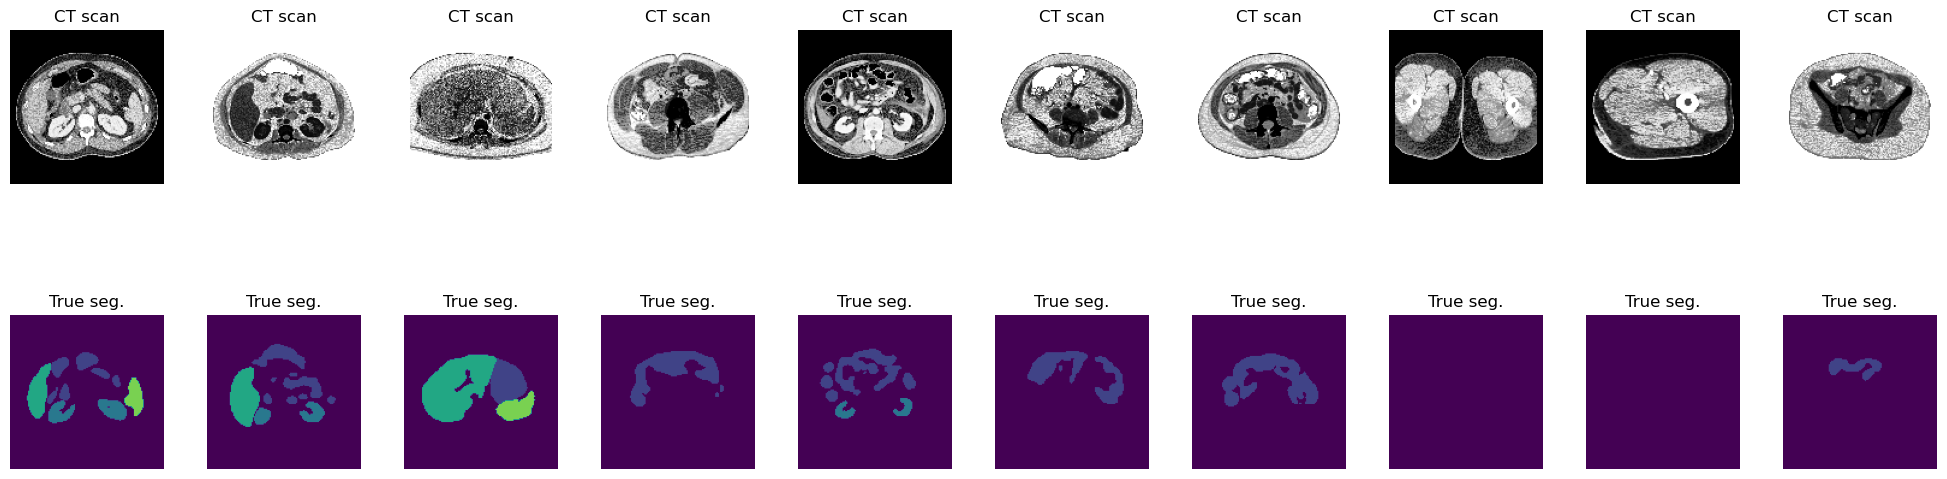

In [10]:
image_batch = next(iter(train_dataloader))
inds = [int(i) for i in np.linspace(0, image_batch[0].shape[0] - 1, 10)]
_ = plot_sample(image_batch, cfg.segmentation_dict, index=inds)

### Define a UNET and instantiate one

In [11]:
class unet(nn.Module):
    def __init__(self, CHANNEL_LIST, OUTPUT_CHANNEL=1):
        super().__init__()
        self.encoder_block = encoder(CHANNEL_LIST[:-1]) # 128 channels
        self.flat_block = conv_block(CHANNEL_LIST[-2], CHANNEL_LIST[-1]) # 256 channels
        self.decoder_block = decoder(CHANNEL_LIST[::-1][:-1]) # 16 channel
        self.output_block = conv_block(CHANNEL_LIST[1], OUTPUT_CHANNEL) # 1 channel
        
    def forward(self, x):
        encoder_outputs, x = self.encoder_block(x)
        x = self.flat_block(x)
        x = self.decoder_block(x, encoder_outputs)
        x = f.softmax( self.output_block(x), dim=1)
        return x

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 7, padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 7, padding='same')

    def forward(self, x):
        x = f.relu( self.batchnorm1( self.conv1(x) ) )
        x = self.conv2(x)
        return x

class encoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
        self.maxpool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout2d(0.1)
        
    def forward(self, x):
        encoder_outputs = []
        for block in self.blocks:
            x = block(x)
            encoder_outputs.append(x)
            x = self.maxpool(x)
#             x = self.dropout(x)
        return encoder_outputs, x
    
class decoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.upsamples = nn.ModuleList([
            nn.ConvTranspose2d(channel_list[i], channel_list[i+1], 2, 2)  
            for i in range(len(channel_list)-1)
        ])
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
    
    def forward(self, x, encoder_outputs):
        encoder_outputs_reversed = encoder_outputs[::-1]
        
        for ind, (upsample, block) in enumerate( zip(self.upsamples, self.blocks) ):            
            x = upsample(x) # doubles the spatial dimension and decrease channels
            x = torch.cat([x, encoder_outputs_reversed[ind]], dim=1) # channels are increased again
            x = block(x) # decrease number of channels
        return x

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)

### Train the UNet

In [ ]:
# # loss function emphasizes misses than false positives
# train_dataset = RSNA_for_UNet(UNet_train_labeled, cfg, transform=train_transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# class_weights = next(iter(train_dataloader))[1].movedim(1,0)
# class_weights = class_weights.reshape(class_weights.shape[0], class_weights.shape[1], -1).sum(dim=-1)
# class_weights = torch.where( class_weights == 0, torch.nan, class_weights)

# class_weights = torch.nanmean(class_weights, dim=1)
# class_weights = 1 / class_weights
# class_weights = class_weights.max() / class_weights
# cfg.UNet['class_weights'] = class_weights

class_weights = Variable(torch.tensor([1,2,1,1,1]).to(cfg.device), requires_grad=False)
print(class_weights)

In [12]:
model_exists = 1

OUTPUT_CHANNEL = len(cfg.segmentation_dict['final_output'])
UNet = unet(cfg.UNet['channel_list'], OUTPUT_CHANNEL=OUTPUT_CHANNEL).to(cfg.device)
initialize_weights(UNet)
optimizer = optim.Adam(UNet.parameters(), lr=0.000001)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda x: triangular_lr(x, triangle_height=100, triangle_width=len(train_dataloader) * 4))
criterion = tverskyloss(alpha=cfg.UNet['trevsky_alpha'], beta=cfg.UNet['trevsky_beta'], gamma=4/3, reduction='mean', weights=None)

if model_exists:
    UNet.load_state_dict( torch.load( '/kaggle/input/unet256clean/UNet256clean.pth', map_location=cfg.device ) )
    optimizer.load_state_dict( torch.load( '/kaggle/input/unet256clean/optim256clean.pth', map_location=cfg.device ) )
    lr_scheduler.load_state_dict( torch.load( '/kaggle/input/unet256clean/lr_scheduler256clean.pth', map_location=cfg.device ) )
    UNet.eval()

In [ ]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
lrs = []

merge_unlabeled_data = 0
patient_list_seg_train = UNet_train_labeled
UNet_train_unlabeled_updated = UNet_train_unlabeled

for epoch in range(cfg.UNet['n_epochs']):

    # --------------------------------- model training
    gc.collect()
    UNet.train()

    # Update dataloder since we are doing self-supervised algorithm
    if merge_unlabeled_data == 1:
        patient_list_seg_train = pd.concat([patient_list_seg_train, UNet_train_unlabeled_selected])
    else:
        pass

    # create dataloader
    train_dataset = RSNA_for_UNet(patient_list_seg_train, cfg, transform=train_transform)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.UNet['batch_size'], shuffle=True)
    num_channels = train_dataset[0][1].shape[0]


    running_loss = 0
    running_metric = torch.zeros( num_channels )

    for batch_ind, (images, masks) in enumerate(train_dataloader):
        images = images.to(cfg.device).type(torch.float32)
        masks = masks.to(cfg.device).type(torch.float32)

        optimizer.zero_grad()

        # loss 
        output = UNet(images)
        loss = criterion(output, masks)
        running_loss += loss.item() * images.shape[0]        
        
        # accuracy metric
        img1 = f.one_hot( torch.argmax(output.detach().cpu(), dim=1), num_classes=masks.shape[1]).movedim(-1, 1).type(torch.float32)
        img2 = masks.detach().cpu().type(torch.float32)
        this_batch_tversky = tversky_index(img1, img2, alpha=0.5, beta=0.5, reduction='keep_channels')
        running_metric = running_metric + this_batch_tversky * images.shape[0]

        loss.backward()
        optimizer.step()  
        
        current_lr = lr_scheduler.get_lr()[0]
        lrs.append( current_lr )
        lr_scheduler.step()
        print(f'.', end='')
        
    train_losses.append( running_loss / len(train_dataset) )
    train_metrics.append( running_metric / len(train_dataset) )

    
    # --------------------------------- model evaluation
    with torch.no_grad():
        UNet.eval()

        running_loss = 0
        running_metric = torch.zeros( num_channels )

        for (images, masks) in validation_dataloader:
            images = images.to(cfg.device).type(torch.float32)
            masks = masks.to(cfg.device).type(torch.float32)

            # loss
            output = UNet(images)
            output = f.one_hot( torch.argmax(output, dim=1), num_classes=masks.shape[1]).movedim(-1, 1)
            loss = criterion(output, masks)
            
            running_loss += loss.item() * images.shape[0]

            # accuracy metric
            img1 = f.one_hot( torch.argmax(output.detach().cpu(), dim=1), num_classes=masks.shape[1]).movedim(-1, 1).type(torch.float32)
            img2 = masks.detach().cpu().type(torch.float32)
            this_batch_tversky = tversky_index(img1, img2, alpha=0.5, beta=0.5, reduction='keep_channels')
            running_metric = running_metric + this_batch_tversky * images.shape[0]

        test_losses.append( running_loss / len(validation_dataset) )
        test_metrics.append( running_metric / len(validation_dataset) )

        print(f'\n[{epoch+1}/{cfg.UNet["n_epochs"]}]: Train size: {len(train_dataset)} ------------- train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f} -------------  train_tversky={np.array(train_metrics[-1])} / test_tversky={np.array(test_metrics[-1])} -------------  lr={current_lr:.8f}\n\n')
        
        torch.save(UNet.state_dict(), "/kaggle/working/UNet512clean.pth")
        torch.save(optimizer.state_dict(), "/kaggle/working/optim512clean.pth")
        torch.save(lr_scheduler.state_dict(), "/kaggle/working/lr_scheduler512clean.pth")


        # --------------------------------- predict output for unlabeled training data
        try:
            improvement_factor = (test_metrics[-1] - test_metrics[-2]).sum()
        except:
            improvement_factor = 1

        if (cfg.UNet['self_spuervised_learning'] == 1) and (epoch >= 3) and (improvement_factor < 0.10) and len(UNet_train_unlabeled_updated):

            print(f'\n\n\nConsidering {len(UNet_train_unlabeled_updated)} unlabeled data to merge with labeled data')

            UNet_train_unlabeled_dataset = RSNA_for_UNet(UNet_train_unlabeled_updated, downsample_rate=cfg.DS_RATE, transform=validation_transform, segmentation_dict=cfg.segmentation_dict)
            train_unlabeled_dataloader = DataLoader(UNet_train_unlabeled_dataset, shuffle=False, batch_size=cfg.batch_size)

            probs_all_unlabeled = torch.tensor([])
            all_inds_nonzero = []
            previous_batch_size = 0

            for batch_ind, (images, masks) in enumerate(train_unlabeled_dataloader):        
                images = images.to(cfg.device).type(torch.float32)
                masks = masks.to(cfg.device).type(torch.float32)
                output = UNet(images)
                probs = output.detach().cpu()

                # take nonzero masks only                
                conf = confidence_index(probs)
                nonzero_probs_inds = torch.nonzero( conf > cfg.UNet['confidence_threshold'] ).reshape(-1)

                probs_nonzero = probs[list(nonzero_probs_inds), :, :, :]
                probs_all_unlabeled = torch.concat((probs_all_unlabeled, probs_nonzero), dim=0) if probs_all_unlabeled.size else probs_nonzero

                # take note of good inds
                nonzero_probs_inds = (nonzero_probs_inds + previous_batch_size ).tolist()
                all_inds_nonzero.extend( nonzero_probs_inds )

                previous_batch_size = images.shape[0]

                if (batch_ind + 1) % 100 == 0:
                    print(f'[U-B{batch_ind+1}: N={len(all_inds_nonzero)}]', end='')

            # throw out zero samples from patient list
            if len(all_inds_nonzero) == 0:
                merge_unlabeled_data = 0
                print('\nNo good samples found!')
                continue

            print(f'\n{len(all_inds_nonzero)} unlabeled data resulted in nonzero outputs')
            UNet_train_unlabeled_nonzero = UNet_train_unlabeled_updated.iloc[all_inds_nonzero, :].copy()

            # From the nonzero patient_list and nonzero masks find the best ones and save their masks as png for further merging
            UNet_train_unlabeled_selected = save_good_samples(probs_all_unlabeled, UNet_train_unlabeled_nonzero, cfg.save_root)

            # remove whatever is selected
            UNet_train_unlabeled_updated = UNet_train_unlabeled_updated.drop(UNet_train_unlabeled_updated.index[all_inds_nonzero], axis=0)

            print(f'{len(UNet_train_unlabeled_selected)} unlabeled data was merged -- {len(UNet_train_unlabeled_updated)} unlabeled data is still left\n\n')
            merge_unlabeled_data = 1
        else:
            merge_unlabeled_data = 0

In [ ]:
# Save model
UNet.eval()
torch.save(UNet.state_dict(), "/kaggle/working/UNet512clean.pth")
torch.save(optimizer.state_dict(), "/kaggle/working/optim512clean.pth")
torch.save(lr_scheduler.state_dict(), "/kaggle/working/lr_scheduler512clean.pth")

### Visualizer model performance across epochs

In [ ]:
plot_model_performance(losses=[train_losses, test_losses], metrics=[train_metrics, test_metrics], lrs=lrs, cfg=cfg)

### Visually inspect segmentations

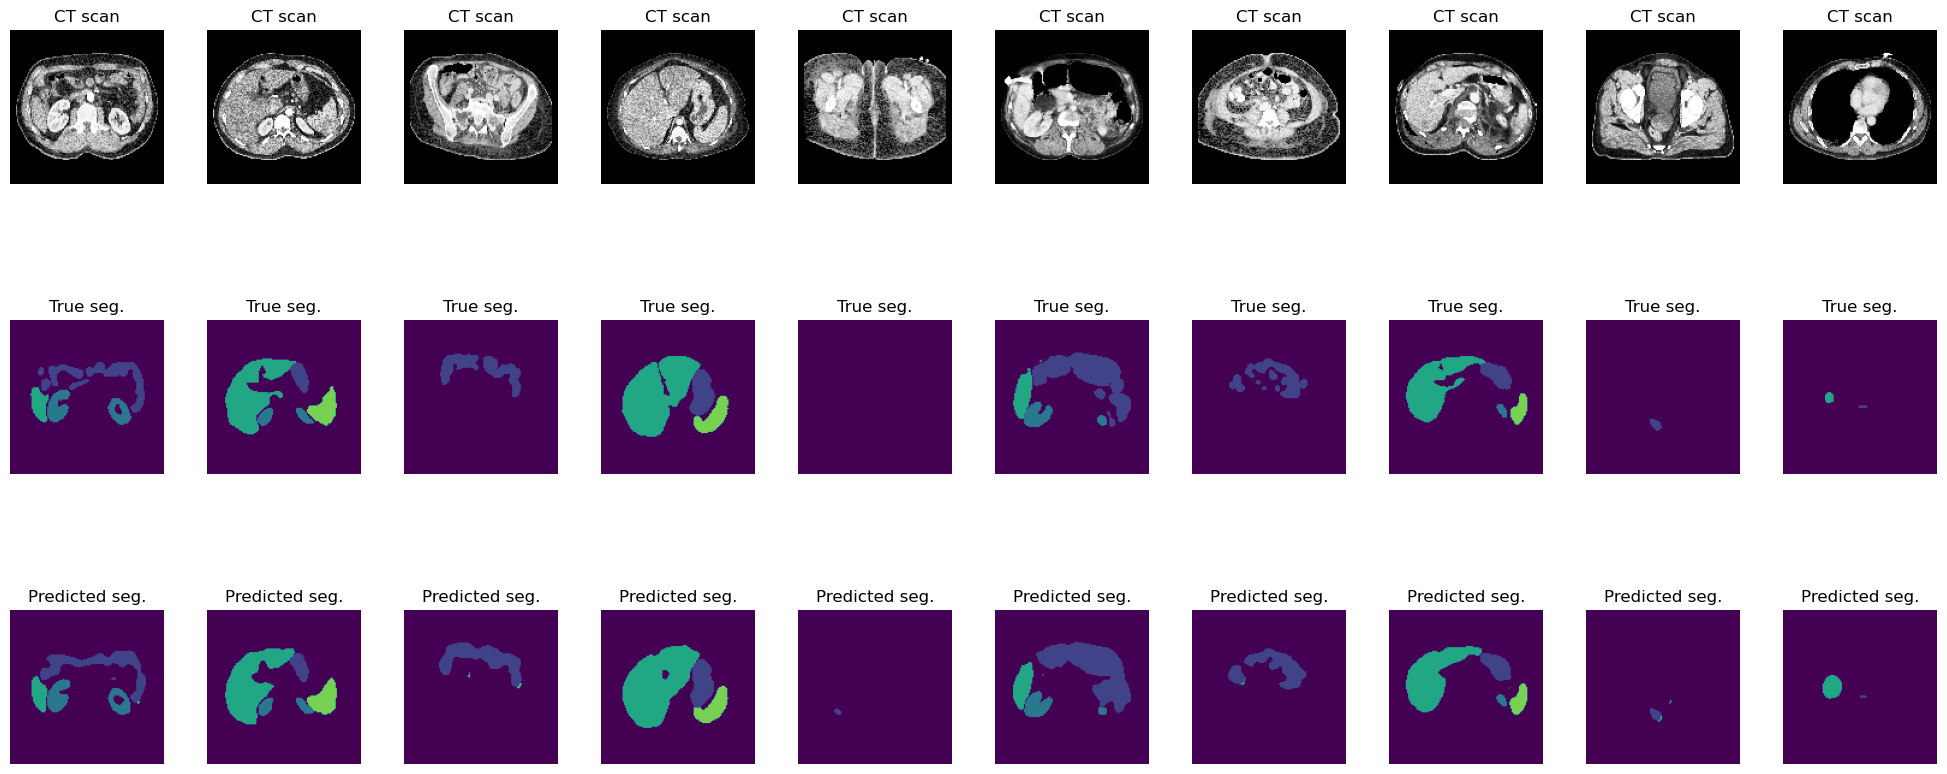

In [14]:
image_batch = next(iter(validation_dataloader))
inds = [int(i) for i in np.linspace(0, image_batch[0].shape[0] - 1, 10)]
image_batch = image_batch + [UNet(image_batch[0]).to(cfg.device).detach().cpu()]
fig, ax = plot_sample(image_batch, cfg.segmentation_dict, index=inds)

# Implement CNN

### Define DataLoaders for CNN which uses UNet output as input

In [ ]:
# Load seg probs (UNet output) to train CNN (Targets: labels)
class RSNA_seg_probs(Dataset):
    def __init__(self, patient_list, model, cfg, mode='train', transform_for_UNet=None, transform_for_CNN=None, output_labels=None):
        self.patient_list = patient_list
        if mode == 'train':
            self.nodeout = convert_pd_to_CNN_targets(patient_list, cfg)
        self.data_path = cfg.data_path
        self.segmentation_dict = cfg.segmentation_dict
        self.mode = mode
        self.model = model
        self.device = cfg.device
        self.transform_for_UNet = transform_for_UNet
        self.transform_for_CNN = transform_for_CNN
        self.cfg = cfg
        
    def __len__(self):
        return len(self.patient_list)
    
    def __getitem__(self, index):
        # extract target labels
        if self.mode == 'train':
            target = torch.tensor( self.nodeout.iloc[index, :] )
        else:
            target = []
        this_patient = self.patient_list.iloc[index, :]
        
        
        # _______________________load CT data
        filename = str(this_patient['instance_number']) + '.dcm'
        file_path = os.path.join(cfg.data_path[self.mode], str(int(this_patient['patient_id'])), str(int(this_patient['series_id'])), filename)
        image = load_CT_slice(file_path)
        

        # _______________________ transform masks
        if self.transform_for_UNet is not None:
            for key, transform in self.transform_for_UNet.items():
                out = transform(image=image)
                image = out['image']
        image = T.ToTensor()(image)                    
        
        
        # -------------------------------------------------- Pass image through UNet
        UNet_input = image.unsqueeze(axis=0).to(self.device)
        seg_probs = self.model( UNet_input ).detach().cpu().squeeze(dim=0)                    
#         N_channels = seg_probs.shape[0]
#         seg_probs = torch.argmax(seg_probs, dim=0).type(torch.float32).unsqueeze(dim=0)  
        
        # -------------------------------------------------- extract each organ's segmentation
#         CNN_input = []
#         for organ_index in range( N_channels ):
#             this_organ_mask = (seg_probs == organ_index)
#             # transform the masked image 
#             image = self.cfg.transform_dict['basic'](image=image_orig)['image'] * this_organ_mask
#             image_norm = self.cfg.transform_dict['normalize'](image=image)['image']
#             CNN_input.append( this_organ_mask )
#         CNN_input = torch.cat(CNN_input, dim=0)

        CNN_input = torch.cat([image, seg_probs], dim=0)
        return (CNN_input, target)

### Define image transformations

In [ ]:
CNN_train_transform_for_UNet = {key: cfg.transform_dict[key] for key in ['basic', 'normalize']}
CNN_train_transform_for_CNN = None

CNN_validation_transform_for_UNet = {key: cfg.transform_dict[key] for key in ['basic', 'normalize']}
CNN_validation_transform_for_CNN = None

### Create dataloaders

In [ ]:
# find patients of this organ
CNN_train_patients = CNN_train.loc[ CNN_train['liver_healthy'] == False ]
patients = np.unique( CNN_train_patients['patient_id'] )[::5]
CNN_train_patients = CNN_train_patients.loc[CNN_train_patients['patient_id'].isin( patients ), :]
print(CNN_train_patients.shape)

# find healthy subjects of this organ
CNN_train_healthy = CNN_train.loc[ CNN_train['liver_healthy'] == True ]
healthy = np.unique( CNN_train_healthy['patient_id'] )[::50]
CNN_train_healthy = CNN_train_healthy.loc[CNN_train_healthy['patient_id'].isin( healthy ), :]
print(CNN_train_healthy.shape)

# merge them
subjects = np.concatenate( (patients, healthy) )
CNN_train_downsampled = CNN_train.loc[ CNN_train['patient_id'].isin(subjects) ]
print(CNN_train_downsampled.shape)

In [ ]:
# find patients of this organ
CNN_validation_patients = CNN_validation.loc[ CNN_validation['liver_healthy'] == False ]
patients = np.unique( CNN_validation_patients['patient_id'] )[::3]
CNN_validation_patients = CNN_validation_patients.loc[CNN_validation_patients['patient_id'].isin( patients ), :]
print(CNN_validation_patients.shape)

# find healthy subjects of this organ
CNN_validation_healthy = CNN_validation.loc[ CNN_validation['liver_healthy'] == True ]
healthy = np.unique( CNN_validation_healthy['patient_id'] )[::30]
CNN_validation_healthy = CNN_validation_healthy.loc[CNN_validation_healthy['patient_id'].isin( healthy ), :]
print(CNN_validation_healthy.shape)

# merge them
subjects = np.concatenate( (patients, healthy) )
CNN_validation_downsampled = CNN_validation.loc[ CNN_validation['patient_id'].isin(subjects) ]
print(CNN_validation_downsampled.shape)

In [ ]:
cfg.CNN['batch_size'] = 64

CNN_train_dataset = RSNA_seg_probs(CNN_train_downsampled, UNet, cfg, transform_for_UNet=CNN_train_transform_for_UNet,transform_for_CNN=CNN_train_transform_for_CNN, output_labels=cfg.output['nodes'])
CNN_train_dataloader = DataLoader(CNN_train_dataset, batch_size=cfg.CNN['batch_size'], shuffle=True)
print(f'CNN train size: {len(CNN_train_dataset)}')

CNN_validation_dataset = RSNA_seg_probs(CNN_validation_downsampled, UNet, cfg, transform_for_UNet=CNN_validation_transform_for_UNet,transform_for_CNN=CNN_validation_transform_for_CNN, output_labels=cfg.output['nodes'])
CNN_validation_dataloader = DataLoader(CNN_validation_dataset, batch_size=cfg.CNN['batch_size'], shuffle=True)
print(f'CNN validation size: {len(CNN_validation_dataset)}')

### extract class weights to fixed unbalanced classes

In [ ]:
class_proportions = torch.tensor(convert_pd_to_CNN_targets(CNN_train_downsampled, cfg).mean().values)

proportion_organs = {}

temp = torch.tensor( [class_proportions[0], 1- class_proportions[0]] )
proportion_organs['bowel'] = temp

temp = torch.tensor( [class_proportions[1], 1- class_proportions[1]] )
proportion_organs['extravasation'] = temp

temp = torch.tensor( 1 / class_proportions[2:5] )
temp = temp / temp.sum()
proportion_organs['kidney'] = temp

temp = torch.tensor( 1 / class_proportions[5:8] )
temp = temp / temp.sum()
proportion_organs['liver'] = temp

temp = torch.tensor( 1 / class_proportions[8:11] )
temp = temp / temp.sum()
proportion_organs['spleen'] = temp

proportion_organs

### Define the CNN model and instantiate one

In [ ]:
class cnn(nn.Module):
    def __init__(self, input_size, output_size, channel_list):
        super().__init__()
        self.conv_blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range( len( channel_list ) - 1 )
        ])
        self.image_size_after_conv = int(input_size[1] / (2 ** (len(channel_list)-1) ))
        self.l1 = nn.Linear(channel_list[-1] * self.image_size_after_conv ** 2, channel_list[-1])
        self.l2 = nn.Linear(channel_list[-1], 32)
        self.l3 = nn.Linear(32, output_size)

    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        
        x = x.reshape(x.shape[0], -1)
        x = f.relu( self.l1(x) )
        x = f.relu( self.l2(x) )
        x = self.l3(x)
        return x
        
class conv_block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, 7, padding='same', bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channel)
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):        
        return self.maxpool( self.batchnorm( f.relu( self.conv(x) ) ) )  

    
class CNN_multi_loss(nn.Module):
    def __init__(self, cfg, proportion_organs):
        super().__init__()
        self.cfg = cfg
        self.proportion_organs = proportion_organs
        
    def forward(self, pred, true):
        loss = calculate_RSNA_metric(pred, true, self.cfg, proportion_organs=self.proportion_organs)
        return loss.mean()
        
def calculate_RSNA_metric(pred, true, cfg, proportion_organs=proportion_organs):       
    weight = ( torch.tensor([1,2]) * proportion_organs['bowel'] ).type(torch.float32).to(cfg.device) 
    weight = weight[1] / weight[0]
    temp_pred = pred[:, 0].reshape(pred.shape[0], 1)
    temp_true = true[:, 0].reshape(true.shape[0], 1)
    bowel_loss = f.binary_cross_entropy_with_logits(temp_pred, temp_true, pos_weight=weight) # bowel
    
    weight = ( torch.tensor([1,6]) * proportion_organs['extravasation'] ).type(torch.float32).to(cfg.device) 
    weight = weight[1] / weight[0]
    temp_pred = pred[:, 1].reshape(pred.shape[0], 1)
    temp_true = true[:, 1].reshape(true.shape[0], 1)
    extravasation_loss = f.binary_cross_entropy_with_logits(temp_pred, temp_true, pos_weight=weight) # extravasation

    weight = (torch.tensor([1,2,4])*proportion_organs['kidney']).to(cfg.device)
    kidney_loss = f.cross_entropy(pred[:, 2:5], true[:, 2:5], weight=weight)
    
    weight = (torch.tensor([1,2,4])*proportion_organs['liver']).to(cfg.device)
    liver_loss = f.cross_entropy(pred[:, 5:8], true[:, 5:8], weight=weight)
    
    weight = (torch.tensor([1,2,4])*proportion_organs['spleen']).to(cfg.device)
    spleen_loss = f.cross_entropy(pred[:, 8:11], true[:, 8:11], weight=weight)

    loss = (bowel_loss + extravasation_loss + kidney_loss + liver_loss + spleen_loss ) / 5
    return loss

In [ ]:
model_exists = 0

cfg.CNN['CNN_inputsize'] = CNN_train_dataset[0][0].shape
cfg.CNN['channel_list'] = [cfg.CNN['CNN_inputsize'][0], 16, 32, 64]
output_size = len(cfg.output['nodes'])

CNN = cnn(cfg.CNN['CNN_inputsize'], output_size, cfg.CNN['channel_list']).to(cfg.device)
initialize_weights(CNN)

optimizer = optim.Adam(CNN.parameters(), lr=0.0001)
criterion = CNN_multi_loss(cfg, proportion_organs)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: triangular_lr(x, triangle_height=10, triangle_width= int(len(CNN_train_dataloader) * 4)))

if model_exists:
    CNN.load_state_dict( torch.load( '/kaggle/input/rsna-cnn64/CNN64.pth', map_location=cfg.device ) )
    optimizer.load_state_dict( torch.load( '/kaggle/input/rsna-cnn64/optimCNN64.pth', map_location=cfg.device ) )
    lr_scheduler.load_state_dict( torch.load( '/kaggle/input/rsna-cnn64/lr_schedulerCNN64.pth', map_location=cfg.device ) )

In [ ]:
train_losses = []
test_losses = []
lrs = []
for epoch in range(cfg.CNN['n_epochs']):
    
    # --------------------------------- model training
    gc.collect()
    CNN.train()
    
    running_loss = 0
    for batch_ind, (images, targets) in enumerate(CNN_train_dataloader):
        images = images.to(cfg.device).type(torch.float32)
        targets = targets.to(cfg.device).type(torch.float32)

        optimizer.zero_grad()

        # loss
        output = CNN(images)
        loss = criterion(output, targets)
        running_loss += loss.item() * images.shape[0]        

        loss.backward()
        optimizer.step()

        current_lr = lr_scheduler.get_lr()[0]
        lrs.append( current_lr )
        lr_scheduler.step()

        print(f'[{loss.item():.2f}]', end='')

    train_losses.append( running_loss / len(CNN_train_dataset) )
    
    
    # --------------------------------- model evaluation
    with torch.no_grad():
        CNN.eval()
        
        running_loss = 0
        running_metric = 0
        
        for (images, targets) in CNN_validation_dataloader:
            images = images.to(cfg.device).type(torch.float32)
            targets = targets.to(cfg.device).type(torch.float32)

            # loss
            output = CNN(images)
            loss = criterion(output, targets)
            running_loss += loss.item() * images.shape[0]

        test_losses.append( running_loss / len(CNN_validation_dataset) )

        print(f'\n[{epoch+1}/{cfg.CNN["n_epochs"]}]: train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f} ------------- lr={current_lr:0.8f}\n\n')

### Train the CNN

In [ ]:
# Save model
CNN.eval()
torch.save(CNN.state_dict(), "/kaggle/working/CNN.pth")
torch.save(optimizer.state_dict(), "/kaggle/working/optimCNN.pth")
torch.save(lr_scheduler.state_dict(), "/kaggle/working/lr_schedulerCNN.pth")

# Manually test your model

In [ ]:
CNN_validation.loc[ CNN_validation.any_injury == 1 ].head(20)

### run model on a patient

In [ ]:
CNN.eval()
this_patient_df = CNN_validation.loc[ CNN_validation.patient_id == 521, :].copy()
CNN_validation_dataset = RSNA_seg_probs(this_patient_df, UNet, cfg, transform_for_UNet=CNN_validation_transform_for_UNet,transform_for_CNN=CNN_validation_transform_for_CNN, output_labels=cfg.output['nodes'])
CNN_validation_dataloader = DataLoader(CNN_validation_dataset, batch_size=cfg.CNN['batch_size'], shuffle=False)
print(f'CNN validation size: {len(CNN_validation_dataset)}')

out = torch.tensor([]).type(torch.float32)
out_true = torch.tensor([]).type(torch.float32)

for images, targets in CNN_validation_dataloader:
    test_images = images.to(cfg.device).type(torch.float32)
    output_this_batch = CNN( test_images ).detach().cpu()
    out = torch.cat([out, output_this_batch], dim=0) if out.numel() else output_this_batch
    out_true = torch.cat([out_true, targets], dim=0) if out_true.numel() else targets
    print('.', end='')

#### output truth about the patient

In [ ]:
df_true = convert_CNN_logits_to_probs(out_true, cfg.output['nodes'], is_target=True)
df_true

#### output prediction for the patient

In [ ]:
pd.DataFrame(post_proc(out), columns=df_true.columns)

In [ ]:
pred_all = create_patient_row(out)
df_pred = pd.DataFrame(pred_all, columns = df_true.columns).round(3)
df_pred

# Evaluate your model on test images

In [ ]:
plot_model_performance(losses=[train_losses, test_losses], metrics=None, lrs=lrs)